In [1]:
import sys
from pathlib import Path

# Enables the notebook to access root:
root_path = Path.cwd().parent
sys.path.append(str(root_path))

from geometry_metrics import compute_spectral_entropy, cosine_similarity_matrix, sliding_window, calculate_angles
from se_correlation import encode_labelset, compute_entropies
import json
import numpy as np
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

def UMAP_projection(embeddings, random_seed = 42):
    reducer = umap.UMAP(random_state=random_seed)
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

c:\Users\Friis\anaconda3\envs\ProjectWorkEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
# Suppress UMAP warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
import clip
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading CLIP ViT-L/14@336px...")
#Force the model to use float32:
model = clip.load("ViT-L/14@336px", jit=False, device=torch.device("cpu"))[0].to(device)

Loading CLIP ViT-L/14@336px...


In [3]:
pca = PCA(n_components=2)
Dataset = "dataset" 

embedding_path = f"../Embeddings/{Dataset}.json"
label_path = f"../Data/{Dataset}/labels.json"

with open(embedding_path, "r", encoding="utf-8") as f:
    embedding_dict = json.load(f)["rot"]

for obj in embedding_dict:
    embedding_dict[obj] = np.array([embedding_dict[obj][key] for key in sorted(embedding_dict[obj].keys())], dtype=np.float32)

In [14]:
Dataset = "coil100" 
label_path = f"../Data/{Dataset}/labels.json"
with open(label_path, "r", encoding="utf-8") as f:
        label_idx_dict = json.load(f)
 
label_names = list(label_idx_dict.keys())
text_features = encode_labelset(label_names, model, device)

Encoding Labelset: 100%|██████████| 9/9 [00:33<00:00,  3.76s/it]


In [83]:
PCA_text = pca.fit_transform(text_features.numpy())
UMAP_text = UMAP_projection(text_features.numpy(), random_seed=42)

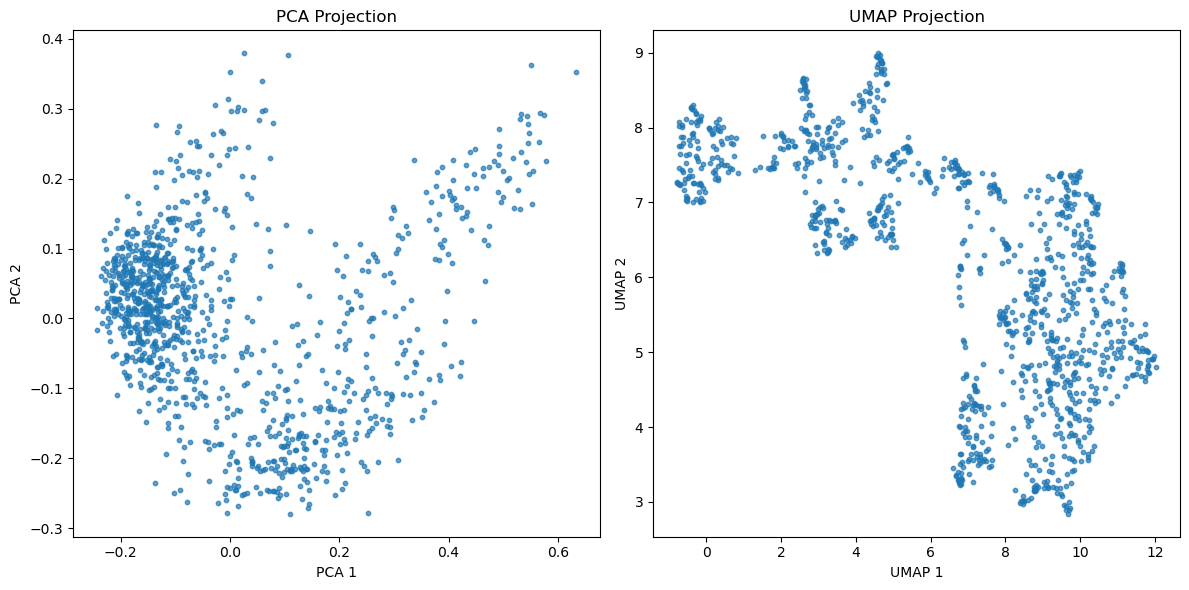

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# PCA plot
axes[0].scatter(PCA_text[:, 0], PCA_text[:, 1], s=10, alpha=0.7)
axes[0].set_title("PCA Projection")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# UMAP plot
axes[1].scatter(UMAP_text[:, 0], UMAP_text[:, 1], s=10, alpha=0.7)
axes[1].set_title("UMAP Projection")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()

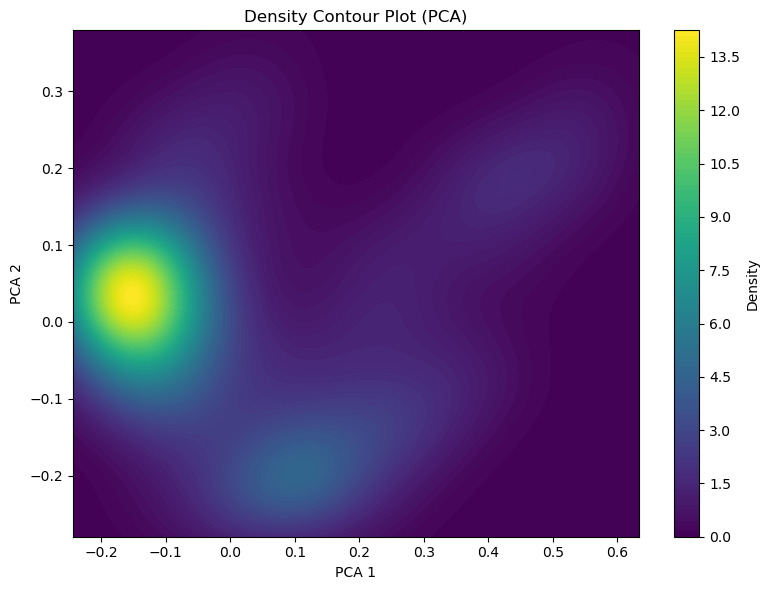

In [25]:

key = "PCA"
dict_ = {"UMAP": UMAP_text, "PCA": PCA_text}
dict_[key]

data = dict_[key].T  # shape -> (2, N) for gaussian_kde
kde = gaussian_kde(data)
x_min, x_max = data[0].min(), data[0].max()
y_min, y_max = data[1].min(), data[1].max()

# Grid for KDE
x_grid, y_grid = np.mgrid[x_min:x_max:300j, y_min:y_max:300j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
density = kde(positions).reshape(x_grid.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, density, levels = 100, cmap="viridis")
#plt.scatter(data[0], data[1], s=5, color="white", alpha=0.6) #point overlay
plt.title(f"Density Contour Plot ({key})")
plt.xlabel(f"{key} 1")
plt.ylabel(f"{key} 2")
plt.colorbar(label="Density")
plt.tight_layout()
plt.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Explained variance ratio: [0.1279082  0.09628512]
Total explained variance: 0.22419332


C:\Users\Friis\AppData\Local\Temp\ipykernel_10120\1923138725.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


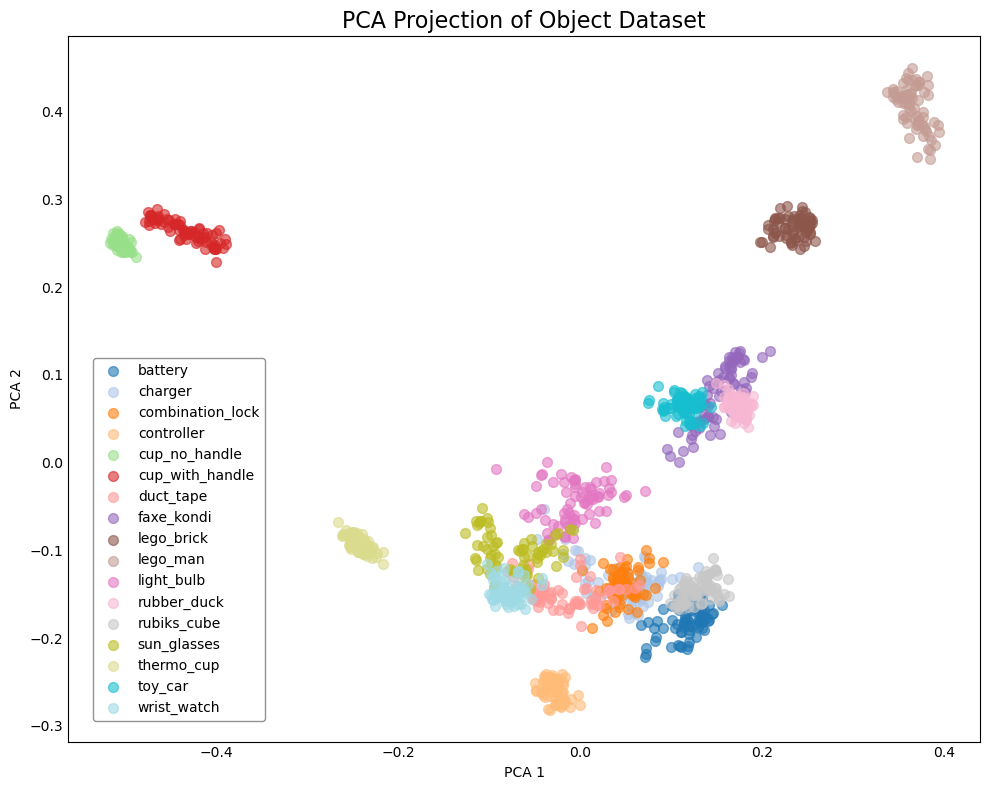

In [147]:

all_embeddings_raw = []
labels = []

print(plt.style.available)

for obj_name, embedding_matrix in embedding_dict.items():
    all_embeddings_raw.append(embedding_matrix)
    labels.extend([obj_name] * embedding_matrix.shape[0])


all_embeddings_raw = np.vstack(all_embeddings_raw)
labels = np.array(labels)

# --- Choose projection method ---
method = "pca"  # or "pca"
if method == "umap":
    model = umap.UMAP(n_components=2, random_state=42)
elif method == "pca":
    model = PCA(n_components=2)
else:
    raise ValueError("Unknown projection method")

projected = model.fit_transform(all_embeddings_raw)

# --- If PCA: get explained variance
if method == "pca":
    print("Explained variance ratio:", model.explained_variance_ratio_)
    print("Total explained variance:", sum(model.explained_variance_ratio_))

unique_labels = sorted(set(labels))
cmap = cm.get_cmap('tab20', len(unique_labels))
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}


plt.style.use('default')
plt.figure(figsize=(10, 8))
for label in unique_labels:
    idxs = labels == label
    plt.scatter(
        projected[idxs, 0],
        projected[idxs, 1],
        color=label_to_color[label],
        label=label,
        s=50,
        alpha=0.6
    )

plt.title("PCA Projection of Object Dataset", fontsize=16)
plt.xlabel(f"{method.upper()} 1")
plt.ylabel(f"{method.upper()} 2")
plt.tick_params(axis='both', which='both', length=0)

if Dataset != "coil100":
    plt.legend(
        #title="Objects",
        loc="lower left",
        bbox_to_anchor=(0.02, 0.02),
        fontsize=10,
        frameon=True,
        framealpha=0.85,     # transparency
        facecolor='white',   # background
        edgecolor='gray',
        markerscale=1
    )

plt.tight_layout()
plt.show()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


C:\Users\Friis\AppData\Local\Temp\ipykernel_9500\3622264710.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_labels))


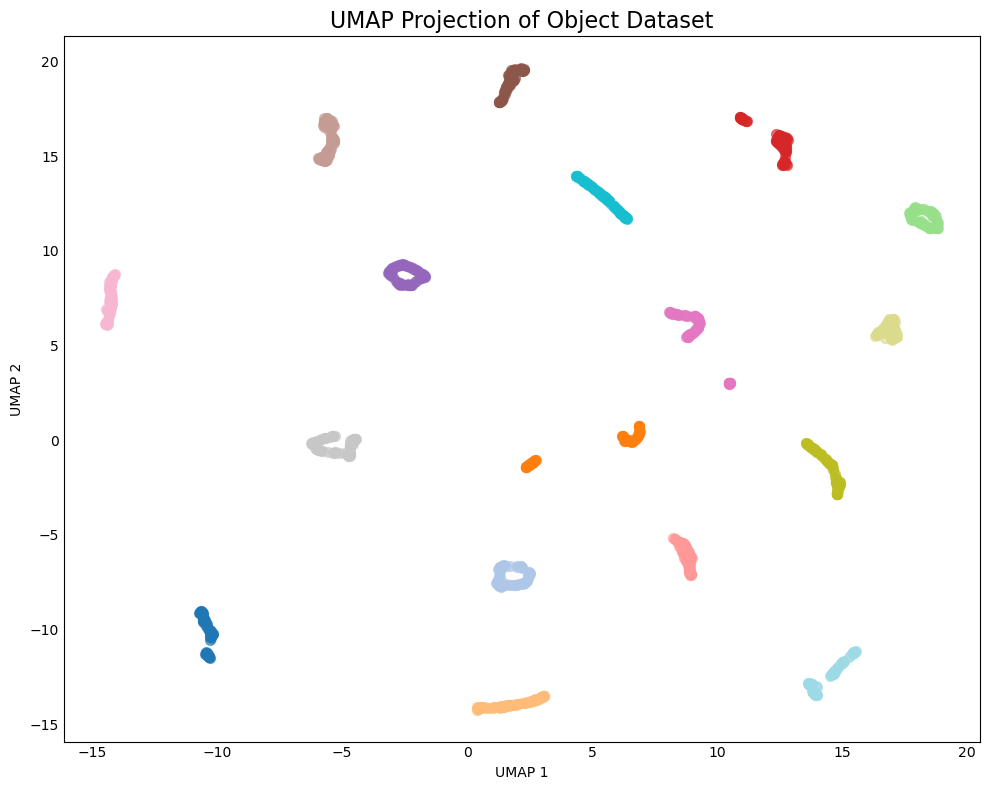

In [99]:

all_embeddings_raw = []
labels = []

print(plt.style.available)

for obj_name, embedding_matrix in embedding_dict.items():
    all_embeddings_raw.append(embedding_matrix)
    labels.extend([obj_name] * embedding_matrix.shape[0])
all_embeddings_raw = np.vstack(all_embeddings_raw)
labels = np.array(labels)

# --- Choose projection method ---
method = "umap"  
if method == "umap":
    model = umap.UMAP(n_components=2, random_state=42)
elif method == "pca":
    model = PCA(n_components=2)
else:
    raise ValueError("Unknown projection method")

projected = model.fit_transform(all_embeddings_raw)

unique_labels = sorted(set(labels))
cmap = cm.get_cmap('tab20', len(unique_labels))
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

plt.style.use('default')
plt.figure(figsize=(10, 8))
for label in unique_labels:
    idxs = labels == label
    plt.scatter(
        projected[idxs, 0],
        projected[idxs, 1],
        color=label_to_color[label],
        label=label,
        s=50,
        alpha=0.6
    )

plt.title("UMAP Projection of Object Dataset", fontsize=16)
plt.xlabel(f"{method.upper()} 1")
plt.ylabel(f"{method.upper()} 2")
plt.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()

In [ ]:
entropy_list = {}

for obj_name, embedding_matrix in embedding_dict.items():
    spectral_entropy = compute_spectral_entropy(cosine_similarity_matrix(embedding_matrix))
    entropy_list[obj_name] = spectral_entropy

for k, v in sorted(entropy_list.items(), key=lambda item: item[1], reverse = True):
    print(f"{k}: {v:.4f}")

# print SE for latex table

faxe_kondi: 0.7088
wrist_watch: 0.6837
combination_lock: 0.5609
lego_man: 0.5605
toy_car: 0.5460
charger: 0.5109
light_bulb: 0.4321
battery: 0.3604
sun_glasses: 0.3381
duct_tape: 0.2852
controller: 0.2571
rubiks_cube: 0.2562
cup_with_handle: 0.1975
rubber_duck: 0.1923
lego_brick: 0.1485
thermo_cup: 0.0849
cup_no_handle: 0.0405


In [ ]:
import matplotlib.colors as mcolors

latex_colors = {
    label: mcolors.to_hex(cmap(i))
    for i, label in enumerate(unique_labels)
}
# return colors for latex table
latex_colors

{np.str_('battery'): '#1f77b4',
 np.str_('charger'): '#aec7e8',
 np.str_('combination_lock'): '#ff7f0e',
 np.str_('controller'): '#ffbb78',
 np.str_('cup_no_handle'): '#98df8a',
 np.str_('cup_with_handle'): '#d62728',
 np.str_('duct_tape'): '#ff9896',
 np.str_('faxe_kondi'): '#9467bd',
 np.str_('lego_brick'): '#8c564b',
 np.str_('lego_man'): '#c49c94',
 np.str_('light_bulb'): '#e377c2',
 np.str_('rubber_duck'): '#f7b6d2',
 np.str_('rubiks_cube'): '#c7c7c7',
 np.str_('sun_glasses'): '#bcbd22',
 np.str_('thermo_cup'): '#dbdb8d',
 np.str_('toy_car'): '#17becf',
 np.str_('wrist_watch'): '#9edae5'}

Encoding Labelset: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

vehicle: 0.2207
car: 0.2220
toy car: 0.2576
grey toy car: 0.2690
small grey toy car: 0.2911
small skoda superb toy car: 0.3408
small skoda superb toy car on a white table with a dim background: 0.3702


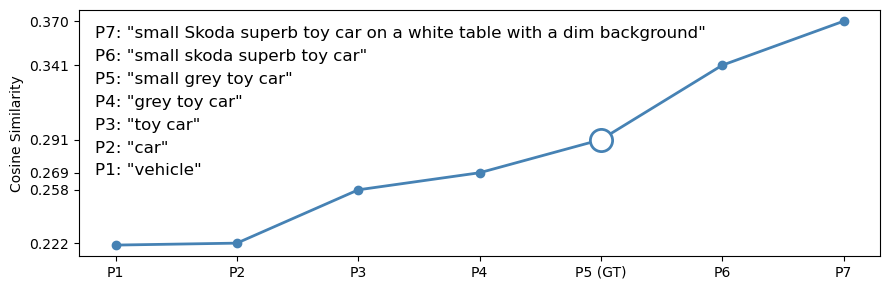

In [ ]:
import torch.nn.functional as F

vect = embedding_dict["toy_car"][0]
vect_torch = torch.tensor(vect, dtype=text_features.dtype, device=text_features.device)

label_names = ["vehicle", "car", "toy car", "grey toy car", "small grey toy car", "small skoda superb toy car","small skoda superb toy car on a white table with a dim background"]

text_features = encode_labelset(label_names, model, device)

vect_torch = F.normalize(vect_torch, dim=0)           # shape (768,)
text_features = F.normalize(text_features, dim=1)     # shape (N, 768)

scores = text_features @ vect_torch
for label, score in zip(label_names, scores):
    print(f"{label}: {score.item():.4f}")

prompts_table = [
    'P7: "small Skoda superb toy car on a white table with a dim background" ',
    'P6: "small skoda superb toy car" ',
    'P5: "small grey toy car" ',
    'P4: "grey toy car" ',
    'P3: "toy car" ',
    'P2: "car" ',
    'P1: "vehicle" '
]

#should be the other way around ohh well
similarities = [0.3702, 0.3408, 0.2911, 0.2690, 0.2576, 0.2220, 0.2207]
xticks = ["P1", "P2", "P3", "P4", "P5 (GT)", "P6", "P7"]

fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(xticks, similarities[::-1], marker='o', linewidth=2, color='steelblue')
ax.set_ylabel("Cosine Similarity")

highlight_index = 4  
ax.plot(
    xticks[highlight_index],
    similarities[::-1][highlight_index],
    marker='o',
    markersize=16,
    markerfacecolor='white',
    markeredgecolor='steelblue',
    markeredgewidth=2,
    label='Highlighted P5'
)

yticks = similarities[::-1][1:]
ytick_labels = [f"{s:.3f}" for s in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

table = plt.table(
    cellText=[[p] for p in prompts_table],
    rowLabels=None,
    loc='upper left',
    bbox=[0, 0.3, 0.2, 0.65],
    cellLoc='left',
    colLoc='left'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1)

# Remove table lines
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

plt.tight_layout()
plt.show()
